# Feature Selection 2
- 기존 파일이 너무 커져서 새로 생성 및 정리함

## 기본설정
### 한글설정

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.unicode_minus'] = False
plt.rc('font', family='NanumGothicCoding')

### 데이터 가져오기

In [2]:
import os
import gdown

id = "10Hpa4YM0KX_Ig0W9w7DbTdq62nF2UThA"
output = "./open.zip"

if not os.path.isdir('./datasets'):
  gdown.download(id=id, output=output)
  gdown.extractall(path=output, to='./datasets')

### 데이터프레임 만들기

In [3]:
import os
import glob
import pandas as pd
from collections import defaultdict

raw_data = defaultdict(pd.DataFrame)

for fname in glob.glob('./**/*.csv', recursive=True):
    df_name = os.path.splitext(os.path.basename(fname))[0]
    raw_data[df_name] = pd.read_csv(fname)

## 패키지 불러오기

In [4]:
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer

In [5]:
kfold = KFold(n_splits=5, shuffle=True, random_state=13)

## 함수 선언

In [6]:
import numpy as np
from sklearn import metrics
from sklearn.ensemble import IsolationForest

# 데이콘에서 제공한 평가함수
def lg_nrmse(gt, preds):
    # 각 Y Feature별 NRMSE 총합
    # Y_01 ~ Y_08 까지 20% 가중치 부여
    all_nrmse = []
    for idx in range(0,14): # ignore 'ID'
        rmse = metrics.mean_squared_error(gt[:,idx], preds[:,idx], squared=False)
        nrmse = rmse/np.mean(np.abs(gt[:,idx]))
        all_nrmse.append(nrmse)
    score = 1.2 * np.sum(all_nrmse[:8]) + 1.0 * np.sum(all_nrmse[8:14])
    return score


# 컬럼 인덱스 함수
def column_index(X, column):
    for i, v in enumerate(X.columns):
        if v == column:
            return i

def minmax_outlier_index(cname, weight):
    data = raw_data['train'][[cname]].copy()
    mms = MinMaxScaler()
    data[cname+'_mms'] = mms.fit_transform(data[cname].values.reshape(-1, 1))
    return data[data[cname+'_mms'] > weight].index

def value_outlier_index(cname, min_value, max_value):
    data = raw_data['train'][[cname]].copy()
    return data[(data[cname] < min_value) | (data[cname] > max_value)][cname].index

def isolation_outlier_index(cname, contamination):
    data = raw_data['train'][[cname]].copy()
    algorithm = IsolationForest(n_estimators=100, random_state=13
                                , contamination=contamination)
    outlier = algorithm.fit_predict(data[cname].values.reshape(-1, 1))
    outlier_index = [ i for i, v in enumerate(outlier) if v == -1]
    return outlier_index

## Feature X_31

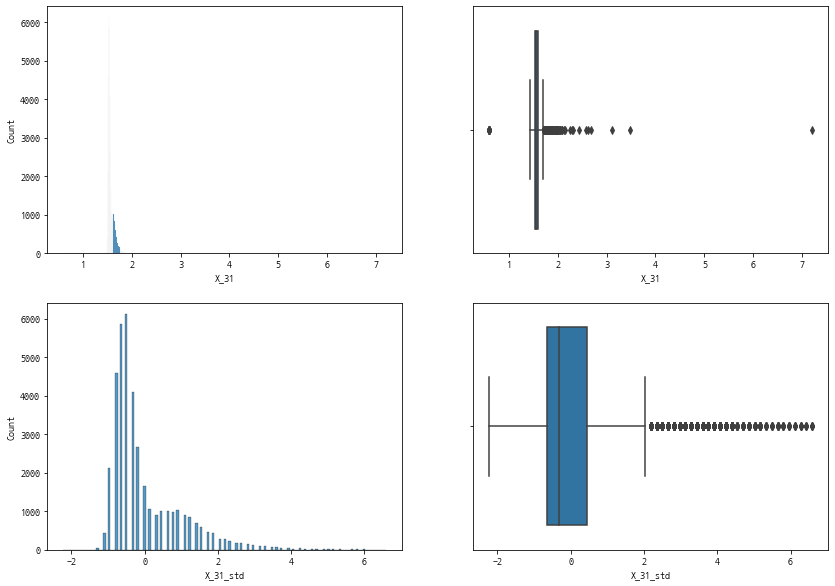

In [7]:
def display_x31_plot(cname):
    data = raw_data['train'][[cname]].copy()
    
    fig, ax = plt.subplots(2, 2, figsize=(14, 10))
    # 원본 히스토그램
    sns.histplot(x=cname, data=data, ax=ax[0][0])
    sns.boxplot(x=cname, data=data, ax=ax[0][1])

    # 이상치 삭제 후 StandardScaler적용
    data[cname+'_std'] = data[(data[cname] > 1) & (data[cname] < 2)][cname]
    ss = StandardScaler()
    data[cname+'_std'] = ss.fit_transform(data[cname+'_std'].values.reshape(-1, 1))
    sns.histplot(x=cname+'_std', data=data, ax=ax[1][0])
    sns.boxplot(x=cname+'_std', data=data, ax=ax[1][1])

    plt.show()

display_x31_plot('X_31')

In [25]:
train = raw_data['train'].drop(columns=['X_04', 'X_23', 'X_47', 'X_48', 'X_02', 'X_10', 'X_11', 'X_46']).copy()

outlier_index = []
outlier_index.extend(minmax_outlier_index(cname='X_38', weight=0.2))
outlier_index.extend(minmax_outlier_index(cname='X_39', weight=0.8))
outlier_index.extend(value_outlier_index(cname='X_31', min_value=1, max_value=2))
outlier_index.extend(isolation_outlier_index(cname='X_07', contamination=0.013))
outlier_index.extend(isolation_outlier_index(cname='X_14', contamination=0.001))
outlier_index.extend(isolation_outlier_index(cname='X_22', contamination=0.001))
outlier_index.extend(isolation_outlier_index(cname='X_24', contamination=0.003))
outlier_index.extend(isolation_outlier_index(cname='X_25', contamination=0.002))
outlier_index.extend(isolation_outlier_index(cname='X_26', contamination=0.003))
outlier_index.extend(isolation_outlier_index(cname='X_50', contamination=0.002))
outlier_index.extend(isolation_outlier_index(cname='X_51', contamination=0.002))
outlier_index.extend(isolation_outlier_index(cname='X_52', contamination=0.002))
outlier_index.extend(isolation_outlier_index(cname='X_53', contamination=0.002))
outlier_index.extend(isolation_outlier_index(cname='X_54', contamination=0.002))
outlier_index.extend(isolation_outlier_index(cname='X_55', contamination=0.002))
outlier_index.extend(isolation_outlier_index(cname='X_56', contamination=0.002))
train = train.drop(outlier_index, axis=0).copy()

len(train)

38468

In [26]:
X = train.filter(regex='X')
y = train.filter(regex='Y')

lst_cols = []
lst_cols.append(column_index(X, 'X_08'))
lst_cols.append(column_index(X, 'X_49'))

mlt_cols = []
mlt_cols.append(column_index(X, 'X_38'))
mlt_cols.append(column_index(X, 'X_39'))

std_cols = set(X.columns) - set(['X_08', 'X_49']) - set(['X_38', 'X_39'])
std_cols = [column_index(X, v) for v in sorted(std_cols)]
len(X.columns), len(std_cols), len(lst_cols), len(mlt_cols)

(48, 44, 2, 2)

In [27]:
# log1p -> StandardScaler 파이프라인
log_std_transformer = Pipeline(
        steps=[
            ("log1p", FunctionTransformer(np.log1p))
          , ("std", StandardScaler())]
    )

# MinMax -> log1p -> StandardScaler 파이프라인
min_log_transformer = Pipeline(
        steps=[("minmax", MinMaxScaler())
        , ("log1p", FunctionTransformer(np.log1p))
        , ("std", StandardScaler())]
    )
    
preprocessor = ColumnTransformer(
      transformers=[
          ("lst", log_std_transformer, lst_cols),
          ("mlt", min_log_transformer, mlt_cols),
          ("std", StandardScaler(), std_cols)
      ]
    )

pipe = Pipeline([
    ('preprocessing', preprocessor),
    ('feature_selection', SelectFromModel(estimator=RandomForestRegressor(n_estimators=250, n_jobs=-1))),
    ('regression', RandomForestRegressor(n_estimators=250, max_depth=30, n_jobs=-1))
])

hyper_params = [{
    'feature_selection__max_features': [20]
    }]

model_cv = GridSearchCV(pipe, hyper_params, cv=kfold, scoring=make_scorer(lg_nrmse, greater_is_better=False)
                        , verbose=3)
model_cv.fit(X.values, y.values)                        

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END feature_selection__max_features=20;, score=-1.942 total time= 2.3min
[CV 2/5] END feature_selection__max_features=20;, score=-1.961 total time= 2.3min
[CV 3/5] END feature_selection__max_features=20;, score=-1.997 total time= 2.3min
[CV 4/5] END feature_selection__max_features=20;, score=-1.956 total time= 2.3min
[CV 5/5] END feature_selection__max_features=20;, score=-1.962 total time= 2.3min


GridSearchCV(cv=KFold(n_splits=5, random_state=13, shuffle=True),
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('lst',
                                                                         Pipeline(steps=[('log1p',
                                                                                          FunctionTransformer(func=<ufunc 'log1p'>)),
                                                                                         ('std',
                                                                                          StandardScaler())]),
                                                                         [5,
                                                                          40]),
                                                                        ('mlt',
                                                                         Pipeline(steps=[('minmax',
                   

In [28]:
model_cv.best_score_

-1.9636707613833633

In [29]:
if model_cv.best_score_ > base_score:
    print('base_score changed: {}'.format(model_cv.best_score_ - base_score))
    base_score = model_cv.best_score_

base_score changed: 0.000988042637803943


In [30]:
selector = model_cv.best_estimator_['feature_selection']

selected_columns = X.columns
selected_columns = selected_columns[selector.get_support()]
len(selected_columns), selected_columns

(18,
 Index(['X_01', 'X_03', 'X_08', 'X_09', 'X_13', 'X_14', 'X_22', 'X_24', 'X_25',
        'X_26', 'X_40', 'X_50', 'X_51', 'X_52', 'X_53', 'X_54', 'X_55', 'X_56'],
       dtype='object'))

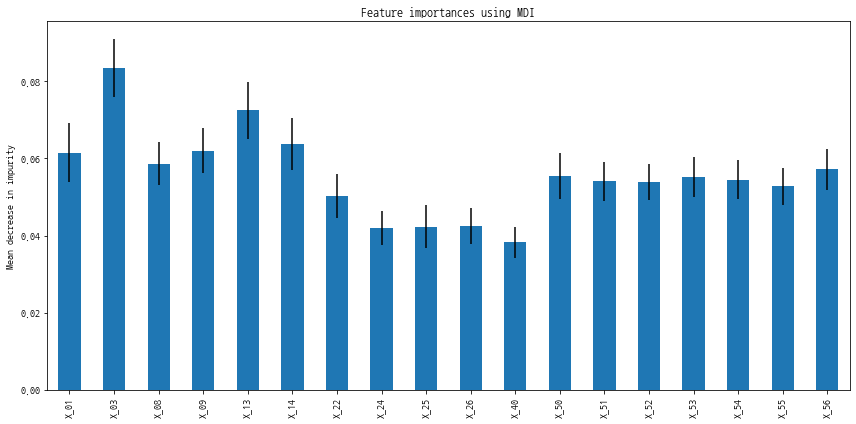

In [31]:
model = model_cv.best_estimator_['regression']

importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)

forest_importances = pd.Series(importances, index=selected_columns)

fig, ax = plt.subplots(figsize=(12,6))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
